# Language Model trained with MLP

- Context window is 3 tokens wide.
- Much superior to Bigram.
- This implementation will be a character language model, i.e., given a sequence of characters, it will predict the next character in the sequence.

In [60]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [61]:
device = torch.device('cpu')

### Load 'names.txt' Dataset

In [62]:
names = open('names.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 32033, emma, olivia, ava, isabella, sophia, ...


### Dictionaries to convert characters to int and back

In [35]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

### Define Block Size

It is the size of the context window. Here, 3 characters are used as it provides a good balance, according to the dataset.

In [36]:
block_size = 3

Using a rolling window to create dataset. `.` character is used as the delimiter.

In [37]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            # print(''.join(itoc[c] for c in context) + ' ---> ' + itoc[ci])
            context = context[1:] + [ci]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


In [38]:
X, Y = build_dataset(names, block_size=block_size)

In [39]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

### Splitting Data into Training, Validation and Testing

- Training data proportion: 80%     [`Xtrn, Ytrn`]
- Validation data proportion: 10%   [`Xdev, Ydev`]
- Testing data proportion: 10%      [`Xtst, Ytst`]

Data is shuffled to get more accurate results when testing on Xdev / Xtst

In [63]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [41]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([182509]), torch.Size([22875]), torch.Size([22762]))

### Define Hyper parameters
- `dims`: number of dimensions used for encoding each token
- `hidden_layer`: number of neurons in the hidden layer of the network

In [64]:
dims = 15
hidden_layer = 150

### Define Model parameters

- `C` : Defines the point in the n-dimensional space for each character
  - Size: `vocab_size` x `dims`
- `W1` : Weights for the first layer
  - Size: `(dims * block_size)` x `hidden_layer`
- `b1` : Bias for the first layer
  - Size: `hidden_layer` x `1`
- `W2` : Weights for the second layer
  - Size: `hidden_layer` x `vocab_size`
- `b2` : Bias for the second layer
  - Size: `vocab_size` x `1`

In [65]:
g = torch.Generator(device=device).manual_seed(0)
C = torch.randn((27, dims), generator=g, device=device)

W1 = torch.randn((dims*block_size, hidden_layer), generator=g, device=device)
b1 = torch.randn(hidden_layer, generator=g, device=device)

W2 = torch.randn((hidden_layer, 27), generator=g, device=device)
b2 = torch.randn(27, generator=g, device=device)

parameters = [C, W1, b1, W2, b2]
print(f"Total Parameter: {sum(p.nelement() for p in parameters)}")

Total Parameter: 11382


In [66]:
for p in parameters:
    p.requires_grad = True

In [45]:
losstrn = [] # For tracking loss during training

Function to calculate loss on given dataset

In [46]:
def getloss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view((-1, block_size*dims)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

### Training
- `nitr` : Number of iterations - Set to 600K
- `lrs` : Array of learning rates - linear decay from 0.1 to 0.005
- Batch size for training: 64

In [67]:
nitr = 600000
lrs = torch.linspace(0.1, 0.005, nitr)
for g in range(nitr):
    # batching
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    # forward pass
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view((-1, block_size*dims)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrn[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    losstrn.append(loss)


### Plot of log loss vs iterations

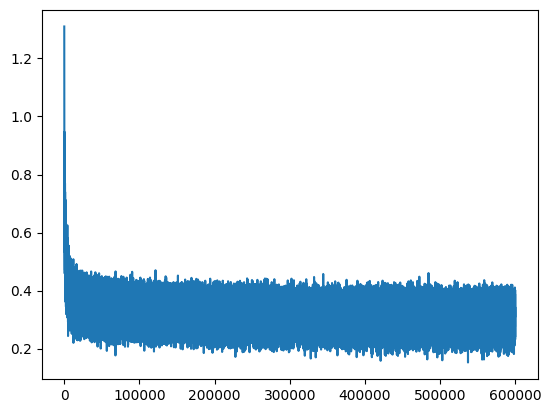

In [71]:
plt.plot(list(map(lambda x: x.log10().item(), losstrn)))

### Print the loss on the training, validation and testing datasets

In [72]:
print(f"Training Loss: {getloss(Xtrn, Ytrn).item()}")
print(f"Validation Loss: {getloss(Xdev, Ydev).item()}")
print(f"Testing Loss: {getloss(Xtst, Ytst).item()}")

Training Loss: 2.0386807918548584
Validation Loss: 2.129159688949585
Testing Loss: 2.109739303588867


### Function to generate a new word based using current model

In [73]:
def generate():
    op = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # print(probs)
        nxti = torch.multinomial(probs, num_samples=1).item()
        if nxti == 0: return ''.join([itoc[x] for x in op])
        context = context[1:] + [nxti]
        op.append(nxti)

### Generate and print 20 samples

In [74]:
for _ in range(20): print(generate())

aus
mekhose
kymchy
brylahbobilroenelia
clanim
jaush
demand
rayah
octte
legancyncin
jahliya
miker
sai
aron
tra
tah
quyna
sangeovan
jalonetzat
mica
